<a href="https://colab.research.google.com/github/AzisilhamK463/UAS_PCVK/blob/main/Tubes_PCVK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tugas Besar PCVK

In [52]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [54]:
import os
import imutils
import cv2 as cv
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from imutils.contours import sort_contours
from tensorflow.keras import layers, models
from google.colab.patches import cv2_imshow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [55]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if (logs.get('accuracy') > 0.99):
      print('\nAkurasi mencapai 99%')
      self.model.stop_training = True

callbacks = myCallback()

In [61]:
def load_data(folder_path, target_size=(32, 32)):
    data = []
    labels = []
    label_dict = {}
    label_counter = 0

    for label in os.listdir(folder_path):
        label_dict[label_counter] = label
        label_path = os.path.join(folder_path, label)
        for image_file in os.listdir(label_path):
            image_path = os.path.join(label_path, image_file)

            try:
                # Coba membaca gambar
                image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)

                if image is not None and not image.size == 0:
                    # Resize gambar ke dimensi yang diinginkan
                    image = cv.resize(image, target_size)
                    data.append(image)
                    labels.append(label_counter)
            except Exception as e:
                print(f"Error processing image {image_path}: {str(e)}")

        label_counter += 1

    return np.array(data), np.array(labels), label_dict


def train_ocr_model(folder_path, save_path = "final_model.keras"):
    # Memuat data dari folder huruf
    data, labels, label_dict = load_data(folder_path)

    # Membagi data menjadi train dan test set
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

    # Mengonversi label menjadi one-hot encoding
    y_train = to_categorical(y_train, num_classes=len(label_dict))
    y_test = to_categorical(y_test, num_classes=len(label_dict))

    # Membangun model CNN
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(len(label_dict), activation='softmax'))  # Jumlah kelas sesuai dengan jumlah huruf

    # Kompilasi model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Praproses data untuk format yang diterima oleh model
    X_train = X_train.reshape((X_train.shape[0], 32, 32, 1)).astype('float32') / 255
    X_test = X_test.reshape((X_test.shape[0], 32, 32, 1)).astype('float32') / 255


    # Augmentasi data menggunakan ImageDataGenerator
    datagen = ImageDataGenerator(rotation_range=10, zoom_range=0.1, width_shift_range=0.1, height_shift_range=0.1)
    datagen.fit(X_train)

    # Pelatihan model
    history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=30, validation_data=(X_test, y_test), callbacks = [callbacks])

    # Evaluasi model
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f'Test accuracy: {test_acc}')

    # Simpan model
    model.save(save_path)
    print(f'Model saved to {save_path}')

In [62]:
train_ocr_model("/content/gdrive/MyDrive/PCVK_UAS/dataset/training_dataset")

Epoch 1/30
35/35 [==============================] - 2s 20ms/step - loss: 3.3501 - accuracy: 0.1032 - val_loss: 3.2020 - val_accuracy: 0.1350
Epoch 2/30
35/35 [==============================] - 1s 17ms/step - loss: 2.8605 - accuracy: 0.2612 - val_loss: 2.3021 - val_accuracy: 0.4927
Epoch 3/30
35/35 [==============================] - 1s 15ms/step - loss: 1.9963 - accuracy: 0.5142 - val_loss: 1.5039 - val_accuracy: 0.6569
Epoch 4/30
35/35 [==============================] - 1s 15ms/step - loss: 1.4229 - accuracy: 0.6247 - val_loss: 1.0753 - val_accuracy: 0.7226
Epoch 5/30
35/35 [==============================] - 1s 21ms/step - loss: 1.0317 - accuracy: 0.7142 - val_loss: 0.7428 - val_accuracy: 0.8212
Epoch 6/30
35/35 [==============================] - 1s 24ms/step - loss: 0.8416 - accuracy: 0.7607 - val_loss: 0.5578 - val_accuracy: 0.8686
Epoch 7/30
35/35 [==============================] - 1s 23ms/step - loss: 0.6845 - accuracy: 0.8082 - val_loss: 0.4573 - val_accuracy: 0.9088
Epoch 8/30
35

In [68]:
# Load Model.

load_network = load_model('/content/final_model.keras')
load_network.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 2304)              0         
                                                                 
 dense_6 (Dense)             (None, 128)              

In [64]:
digits = '0I23456789'
letters = 'ABCDEFGHIJKLMNOPQRSTUVWZYZ'
char_list = digits + letters
char_list = [ch for ch in char_list]

In [78]:
# Fungsi preprocessing citra
def preprocess_img(img):
  blur = cv.GaussianBlur(img, (5,5), .5)
  sharpened = cv.addWeighted(img, 1.5, blur,-0.5,0)
  gray = cv.cvtColor(sharpened, cv.COLOR_BGR2GRAY)
  ret, bw = cv.threshold(gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
  kernel = np.ones((2,2),np.uint8)
  closing = cv.morphologyEx(bw, cv.MORPH_CLOSE, kernel)

  return gray, closing

# Define function find contours for contour detection
def find_contours(img):
    conts = cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
    conts = imutils.grab_contours(conts)
    conts = sort_contours(conts, method='left-to-right')[0]
    return conts

# Function to extract roi
def extract_roi(img, x, y, w, h):
    roi = img[y:y+h, x:x+w]
    return roi

# Function for thresholding
def thresholding(img):
    thresh = cv.threshold(img, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
    return thresh

# Function for normalization
def normalization(img):
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=-1)
    return img

# Function for resizing image
def resize_img(img, w, h):
    target_size = (32, 32)

    if w > h:
        new_h = int(target_size[1] * h / w)
        resized = cv.resize(img, (target_size[0], new_h))
    else:
        new_w = int(target_size[0] * w / h)
        resized = cv.resize(img, (new_w, target_size[1]))

    (h, w) = resized.shape
    dX = int(max(0, target_size[0] - w) / 2.0)
    dY = int(max(0, target_size[1] - h) / 2.0)

    filled = cv.copyMakeBorder(resized, top=dY, bottom=dY, right=dX, left=dX, borderType=cv.BORDER_CONSTANT, value=(0, 0, 0))
    filled = cv.resize(filled, target_size)

    return filled

# Function to process box
def process_box(gray, x, y, w, h):
    roi = extract_roi(gray, x, y, w, h)
    thresh = thresholding(roi)
    resized = resize_img(thresh, w, h)
    normalized = normalization(resized)

    # show result
    cv2_imshow(resized)

    return (normalized, (x, y, w, h))

# Function to process KTM image
def process_ktm_image(image, model, char_list):
    gray_ktm, prep_ktm = preprocess_img(image)
    conts_border = find_contours(prep_ktm)

    # Setup min/max width/hight for char
    min_w, max_w = 20, 160
    min_h, max_h = 27, 140
    img_with_contour_ktm = image.copy()
    for c in conts_border:
        (x, y, w, h) = cv.boundingRect(c)
        if(w >= min_w and w <= max_w) and (h >= min_h and h <= max_h):
          roi = gray_ktm[y:y+h, x:x+w]
          thresh = cv.threshold(roi, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)[1]
          cv.rectangle(img_with_contour_ktm, (x, y), (x + w, y + h), (255, 0, 0), 3)
          # cv2_imshow(thresh) # check

    cv2_imshow(img_with_contour_ktm)

    # Extract and process characters
    detected_char = []
    for c in conts_border:
        (x, y, w, h) = cv.boundingRect(c)
        detected_char.append(process_box(gray_ktm, x, y, w, h))

    # Get all char pixel
    pixels = np.array([px[0] for px in detected_char], dtype='float32')

    # Get all box for detected char
    boxes = [box[1] for box in detected_char]

    # Predict characters
    preds = model.predict(pixels)

    img_copy2 = image.copy()
    for (pred, (x, y, w, h)) in zip(preds, boxes):
        i = np.argmax(pred)
        char_detected = char_list[i]
        cv.rectangle(img_copy2, (x, y), (x+w, y+h), (255,0,0), 2)
        cv.putText(img_copy2, char_detected, (x - 10, y - 10), cv.FONT_HERSHEY_COMPLEX, 1, (0,0,255), 2)

    cv2_imshow(img_copy2)

Jumlah Piksel Baris: 3456
Jumlah Piksel Kolom: 4608


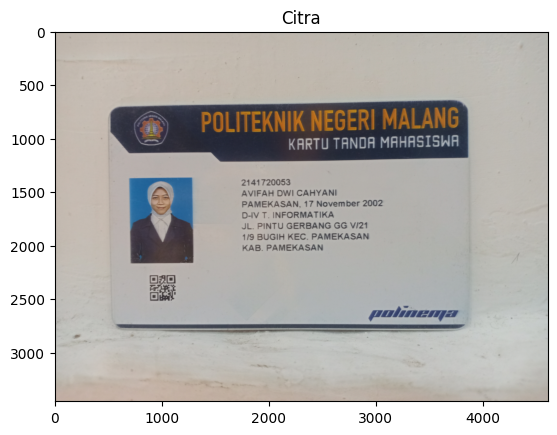

In [65]:
ktm_image_path = cv.imread('/content/gdrive/MyDrive/PCVK_UAS/prediction_test/3E_2141720053_1 - Avifah Dwi Cahyani.jpg')
height, width = ktm_image_path.shape[:2]
print(f'Jumlah Piksel Baris: {height}')
print(f'Jumlah Piksel Kolom: {width}')
plt.imshow(cv.cvtColor(ktm_image_path, cv.COLOR_BGR2RGB))
plt.title('Citra')
plt.show()

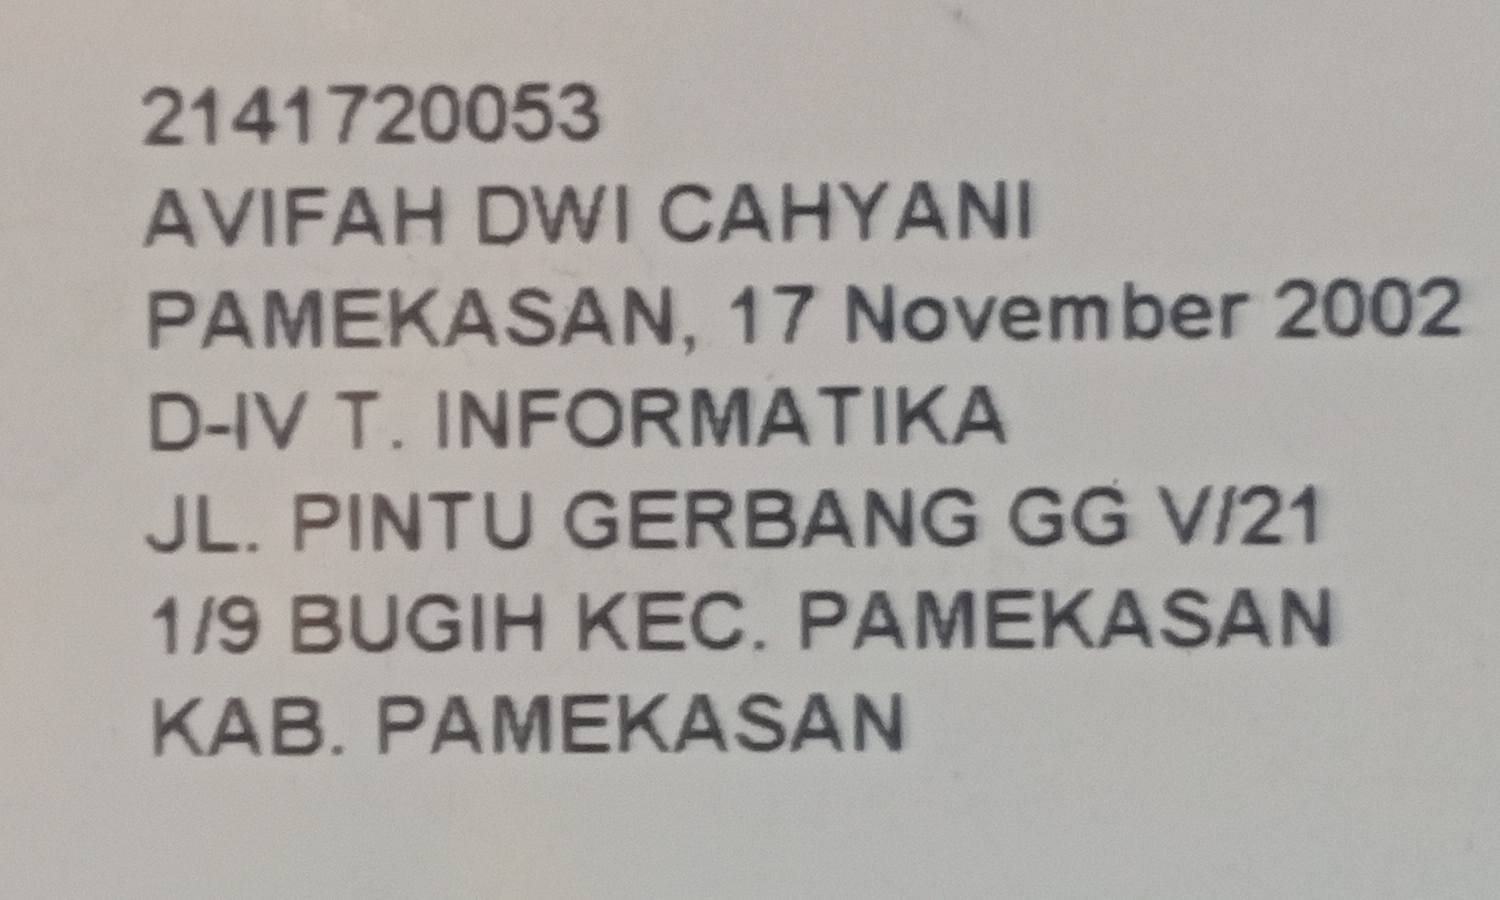

In [66]:
ktm_crop = ktm_image_path[1300:2200,1600:3100]
cv2_imshow(ktm_crop)

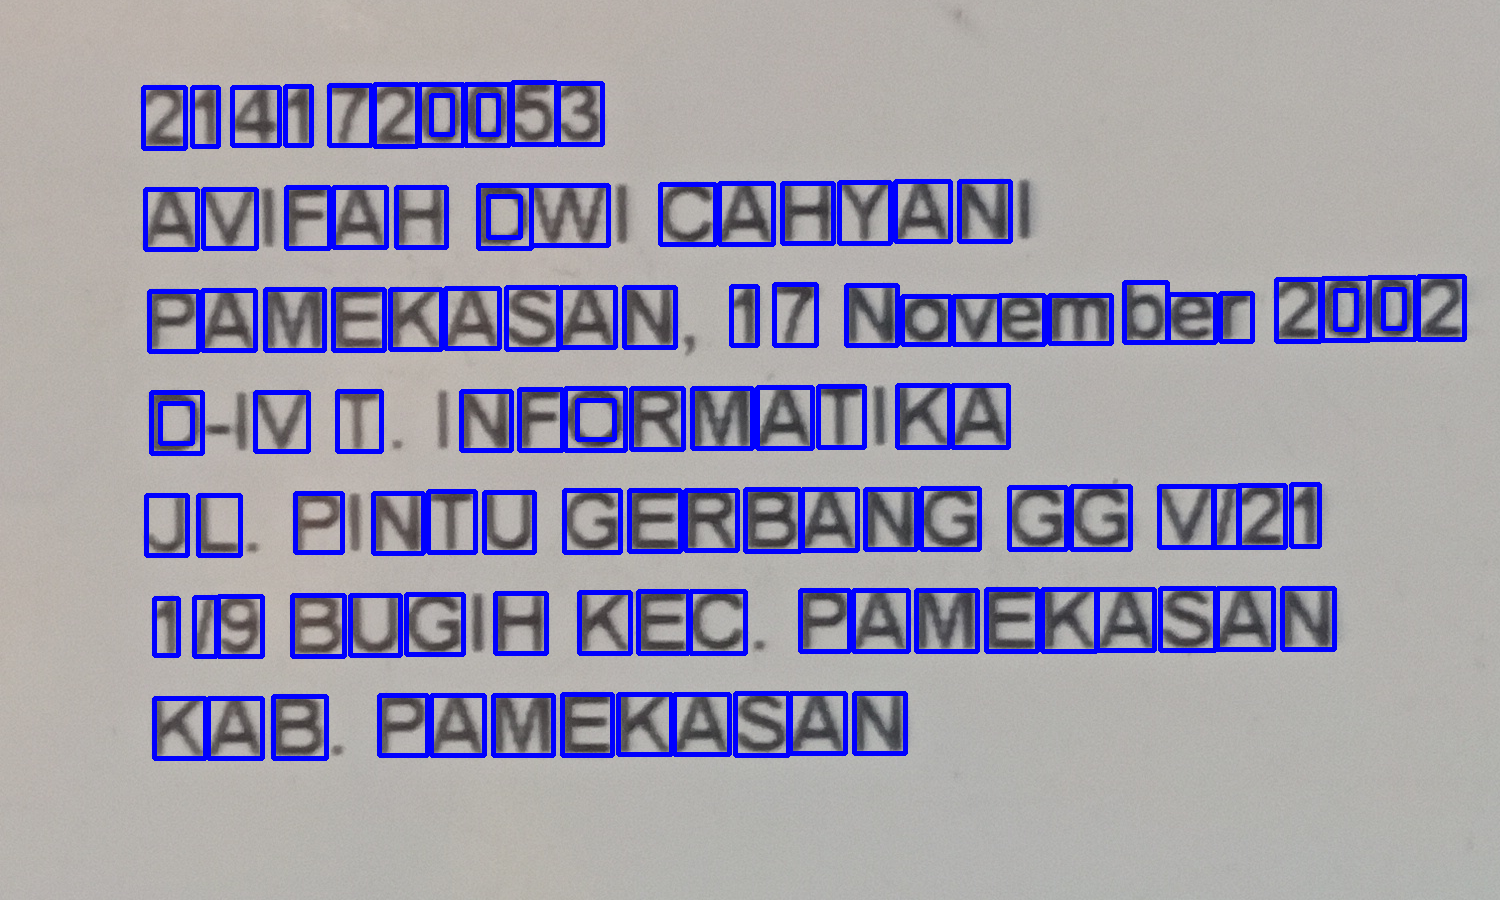

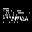

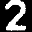

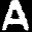

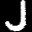

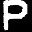

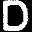

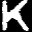

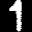

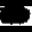

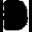

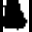

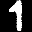

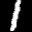

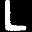

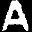

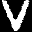

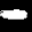

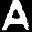

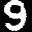

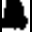

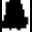

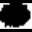

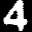

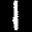

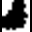

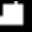

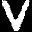

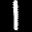

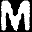

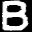

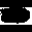

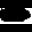

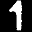

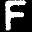

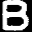

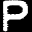

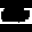

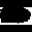

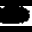

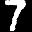

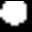

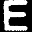

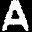

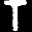

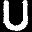

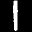

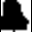

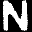

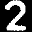

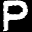

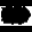

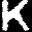

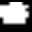

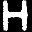

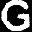

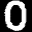

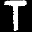

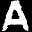

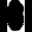

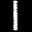

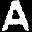

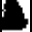

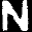

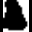

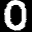

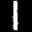

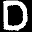

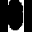

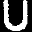

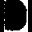

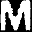

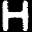

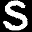

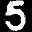

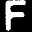

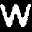

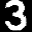

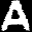

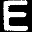

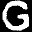

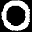

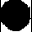

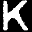

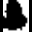

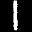

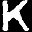

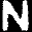

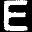

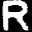

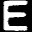

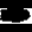

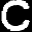

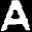

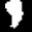

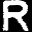

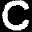

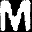

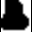

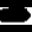

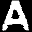

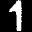

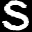

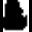

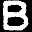

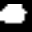

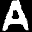

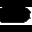

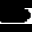

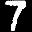

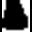

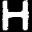

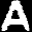

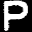

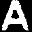

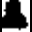

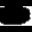

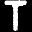

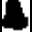

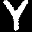

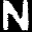

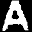

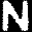

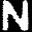

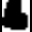

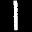

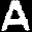

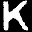

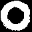

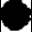

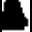

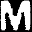

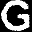

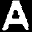

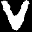

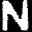

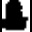

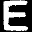

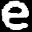

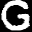

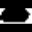

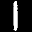

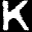

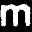

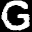

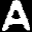

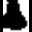

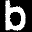

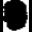

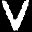

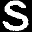

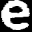

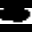

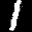

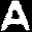

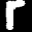

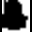

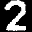

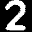

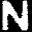

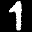

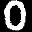

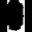

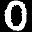

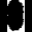

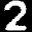

6/6 [==============================] - 0s 3ms/step


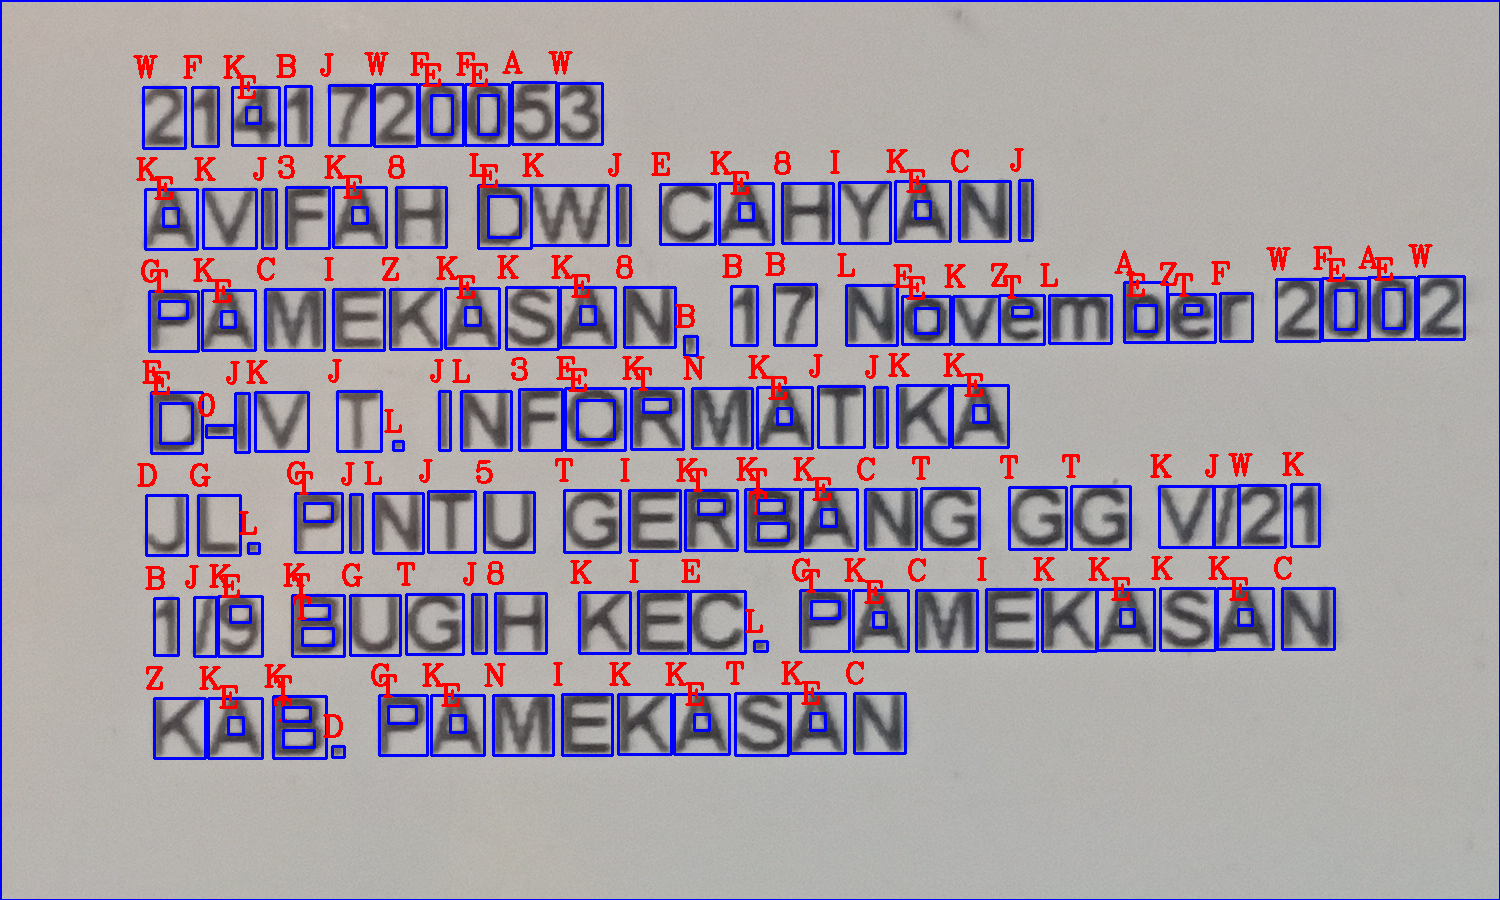

In [79]:
process_ktm_image(ktm_crop, load_network, char_list)